# Notebook说明
本Notebook是对论文*A Suggested Computation for Maximal Multi-Commodity Network Flows*的Python实现。

尝试在较大规模的问题上试验一下这个算法，并看看其对比直接解线性规划的优劣势。

In [185]:
import numpy as np
import networkx as nx

# 指定nbagg后端以启用交互功能
%matplotlib notebook
import matplotlib.pyplot as plt

# 引入一些工具函数用于生成随机连通图
from itertools import combinations, groupby
import random
import time

## 生成随机的多物品最大流问题
主要包含两个问题：
1. 随机生成固定数量的点和边的带权图，该图要求连通，否则可以直接分解为更小规模的问题。
2. 随机生成不同物品，其发点和收点随机

In [29]:
# 随机生成一些含有固定点和边数量的连通图，其权重为最小范围和最大范围的任意数
def generate_graph(node_num, edge_num, min_capacity, max_capacity):
    G = nx.Graph()
    G.add_nodes_from(range(1, node_num+1))
    ei = 1
    
    # 先生成连通图所需的边
    edges = combinations(range(1, node_num+1), 2)
    for _, node_edges in groupby(edges, key=lambda x:x[0]):
        node_edges = list(node_edges)
        random_edge = list(node_edges)
        
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge, weight=random.randint(min_capacity, max_capacity), ei=ei)
        edge_num = edge_num - 1
        ei = ei + 1

        
    # 然后逐步添加随机边直到所有的边用完
    while edge_num > 0:
        p1 = random.randint(1, node_num)
        p2 = random.randint(1, node_num)
        # 两点一样就再随机一次
        if p1 == p2:
            continue
        # 看看图中有没有这样的边了，如果有，那也再随机一次
        if G[p1].get(p2, None) is not None:
            continue
        # 上面都满足的话就在图中添加该边，并让剩余边数-1
        G.add_edge(p1, p2, weight=random.randint(min_capacity, max_capacity), ei=ei)
        edge_num = edge_num-1
        ei = ei + 1
    
    return G

In [86]:
node_num = 20
edge_num = 40
commodity_num = 10

graph_nodes = range(1, node_num+1)
G = generate_graph(node_num, edge_num, 3, 25)

<IPython.core.display.Javascript object>


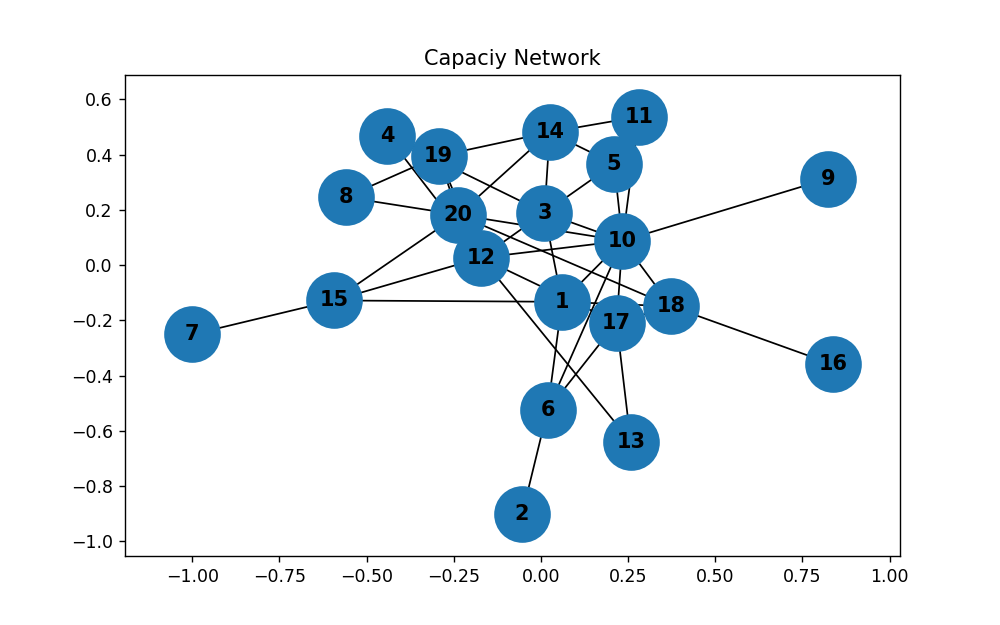

In [87]:
# 绘制图
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Capaciy Network')

edge_labels=nx.get_edge_attributes(G, 'weight')

nx_pos = nx.spring_layout(G) # 弹簧布局
nx.draw(G, nx_pos, with_labels=True, font_weight='bold', ax=ax, node_size=1000)
# 画标签显得比较乱
# nx.draw_networkx_edge_labels(G,nx_pos,edge_labels=edge_labels, ax=ax)

ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [88]:
# 随机生成固定种数的商品，并根据节点个数随机选择source和sink，每个最多允许有max_set_capacity个源点/汇点
def generate_commodity(N, node_num, max_set_capacity=2):
    Source = []
    Sink = []
    
    for i in range(N):
        # 先确定源点和汇点个数
        Ni_source = random.randint(1, max_set_capacity)
        Ni_sink = random.randint(1, max_set_capacity)
        
        # 在1-node_num范围中采样Ni_source+Ni_sink个点，并直接分配出去
        point_list = random.sample(range(1, node_num+1), Ni_sink+Ni_source)
        Source.append(point_list[: Ni_source])
        Sink.append(point_list[Ni_source: Ni_sink+Ni_source])
    
    return Source, Sink

In [89]:
Source, Sink = generate_commodity(commodity_num, node_num)
Source[0:3], Sink[0:3]

([[5], [3], [2, 3]], [[13], [10], [19, 11]])

In [90]:
# 使用Networkx自带的BFS查找算法查找从source到sink的简单路径
# 查找后生产相应的A矩阵
A_list = []

# 记录边的数目
edge_numbers = G.number_of_edges()
# 记录路径的映射
idx = 0
path2Ci = {}
Ci2path = {}
# 记录路径对应的物品
Ci2Commodity = {}


for j in range(len(Source)):
    # 取出商品j的源点和汇点
    sources = Source[j]
    sinks = Sink[j]
    
    # 源点和汇点两两组合，生成简单路径
    for source in sources:
        for sink in sinks:
            # 寻找两点间的简单路径
            simple_paths = nx.all_simple_edge_paths(G, source, sink)
            for path in simple_paths:
                # 对每条路径创建一列
                Ai = np.zeros(edge_numbers)
                nodes = []
                # 将该列每个该路径上的边置为1
                for edge in path:
                    edge_attr = G[edge[0]][edge[1]]
                    # 取出边对应的序号
                    ei = edge_attr['ei']
                    # 对应的位置赋值1
                    Ai[ei-1] = 1
                    # 记录端点
                    nodes.append(edge[0])
                # 记录映射
                nodes.append(edge[1])
                # path2Ci时，由于不同商品可能存在相同的路径，所以这边的值应该是个列表
                if path2Ci.get(', '.join(str(node) for node in nodes), None) is None:
                    path2Ci[', '.join(str(node) for node in nodes)] = [idx]
                else:
                    path2Ci[', '.join(str(node) for node in nodes)].append(idx)
                # path2Ci[', '.join(str(node) for node in nodes)] = idx
                Ci2path[idx] = ', '.join(str(node) for node in nodes)
                Ci2Commodity[idx] = j
                idx += 1
                # 路径处理完后将该列加入A中
                A_list.append(Ai)
# 将所有列拼接，并转置成论文上的A矩阵形状
A = np.vstack(A_list).T
# 记录路径的数量，记为NC
NC = len(Ci2path)
A

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [91]:
A.shape

(40, 111532)

In [92]:
NC

111532

In [93]:
# 创建b向量和C向量
b = np.zeros(edge_numbers)
for n1, n2, data in G.edges(data=True):
    b[data['ei']-1] = data['weight']

C = np.hstack((np.ones(NC), np.zeros(edge_numbers)))

## 导出A矩阵、b向量和C向量
导出A矩阵、b向量和C向量，在其他求解器中求解该线性规划问题，印证答案可靠性。

In [94]:
# 将A矩阵、b向量和C向量导出为csv文件
np.savetxt('A_matrix.csv', A, delimiter=',')
np.savetxt('b_vector.csv', b, delimiter=',')
np.savetxt('c_vector.csv', np.ones(NC), delimiter=',')
print("导出成功!")

导出成功!


In [189]:
b, C

(array([ 4., 16.,  4., 12.,  5.,  3., 13.,  3.,  6., 24., 25.,  9.,  4.,
         8.,  9.,  9., 17.,  6., 23., 11.,  8., 21.,  9., 25.,  6., 17.,
        12.,  3., 24.,  9.,  3., 17.,  7., 14., 22., 19., 13.,  9.,  7.,
        19.]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [190]:
# 建立数学模型
# 首先，引入松弛变量，拓展A矩阵
A_extend = np.hstack((A, np.eye(edge_numbers)))

# 准备初始基矩阵，为了解决问题的一般性，选择xn+1~xn+r
B_idx = np.arange(NC,NC+edge_numbers)
# 初始B矩阵
B = A_extend[:, B_idx]

# 单纯形乘子
CB = C[B_idx]
B_inv = np.linalg.inv(B)
simplex_multipliers = np.dot(CB, B_inv) # alpha_r = CB * B-1

print("初始基矩阵B：")
print(B)
print("单纯形乘子值：")
print(simplex_multipliers)

初始基矩阵B：
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形乘子值：
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [191]:
# 输入单纯形算子、源点、汇点，返回第一个找到的路径
def get_entry_basis_vector(simplex_multipliers):
    # 新建一个图
    LG = nx.Graph()
    # 加入节点
    LG.add_nodes_from(graph_nodes)
    # 加入边和权重，注意权重为这边的单纯形算子
    for n1, n2, data in G.edges(data=True):
        LG.add_edge(n1, n2, weight=simplex_multipliers[data['ei']-1], ei=data['ei'])
        

    # 已知边里面已经没有负权了，所以用Dijkstra算法找最短路是个更好的选择
    # 为了避免重复计算相同的最短路径，可以记录下最短路的长度和对应的路径
    shortest_path_length = {}
    shortest_path = {}
    
    # 开始遍历每个商品的源点和汇点
    for j in range(len(Source)):
        sources = Source[j]
        sinks = Sink[j]
        
        for source in sources:
            for sink in sinks:
                if shortest_path.get(f"{source}->{sink}", None) is None:
                    shortest_path[f"{source}->{sink}"] = nx.dijkstra_path(LG, source, sink)
                    shortest_path_length[f"{source}->{sink}"] = nx.dijkstra_path_length(LG, source, sink)
                
                # 如果物品的价值不同，这边也可以改为小于对应的j物品的价值
                if shortest_path_length[f"{source}->{sink}"] < 0.999999999999999:
                    return shortest_path[f"{source}->{sink}"]
    # 如果没有找到，说明已经迭代到最优了，返回None值
    return None

In [192]:
import pdb

In [193]:
# 开始迭代单纯形
max_iter = 1000
start = time.time()
for iter_ in range(max_iter):
    print(f"--------第{iter_+1}轮迭代开始------------")
    entry_basis_vector = get_entry_basis_vector(simplex_multipliers)
    if entry_basis_vector is None:
        print("已找到最优解！")
        break
    
    # 把入基向量转换成列向量的序号
    entry_idx = path2Ci[", ".join(str(node) for node in entry_basis_vector)]
    if not isinstance(entry_idx, int):
        print("找到一条路径对应多个Ci!")
        entry_idx = entry_idx[0]
    print(f"找到入基向量x{entry_idx+1}")
    
    if entry_idx == 7026:
        pdb.set_trace()
    
    # 确定出基向量
    # 定位变换后的入基目标列
    entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
    entry_vector_transformed = np.round(entry_vector_transformed, 6)
    # 计算变换后的b列
    b_transformed = np.dot(B_inv, b)
    b_transformed = np.round(b_transformed, 6) # 舍弃掉多余的位数，否则精度舍入可能将0变为接近0的负数从而引发错误
    if (b_transformed<0).any():
            raise Exception("怎么回事！")
    # 求检验数
    theta = np.zeros(edge_numbers) + np.inf
    theta[entry_vector_transformed>0] = b_transformed[entry_vector_transformed>0] / entry_vector_transformed[entry_vector_transformed>0]
    # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
    position = np.argmin(theta)

    print(f"确定出基向量x{B_idx[position]+1}")
    # 出基！
    B_idx[position] = entry_idx
    
    # 善后一下，算一下B逆和单纯形乘子
    B = A_extend[:, B_idx]
    B_inv = np.linalg.inv(B)
    CB = C[B_idx]
    simplex_multipliers = np.dot(CB, B_inv)
    # simplex_multipliers = np.round(simplex_multipliers, 6)
    
    if (b_transformed<0).any():
            raise Exception("这里可能有问题！")
    
    # 如果发现存在单纯形算子中存在负数，执行预定的换基操作
    while (simplex_multipliers<0).any():
        if (b_transformed<0).any():
            raise Exception("b出问题了！")
        print("单纯形乘子中存在负数，正在处理...")
        print("当前单纯形乘子:")
        print(simplex_multipliers)
        negative_position = np.argmin(simplex_multipliers)
        print(f"出问题前的基变量:{B_idx[negative_position]}")
        # B_idx[negative_position] = NC + negative_position
        entry_idx = NC + negative_position
        # 定位变换后的入基目标列
        entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
        entry_vector_transformed = np.round(entry_vector_transformed, 6)
        
        b_transformed = np.dot(B_inv, b)
        b_transformed = np.round(b_transformed, 6)
        if (b_transformed<0).any():
                raise Exception("怎么回事！")
        # 求检验数
        theta = np.zeros(edge_numbers) + np.inf
        theta[entry_vector_transformed>0] = b_transformed[entry_vector_transformed>0]\
                                            / entry_vector_transformed[entry_vector_transformed>0]
        # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
        position = np.argmin(theta)

        print(f"确定出基向量x{B_idx[position]+1}")
        # 出基！
        B_idx[position] = entry_idx
        B = A_extend[:, B_idx]
        B_inv = np.linalg.inv(B)
        CB = C[B_idx]
        simplex_multipliers = np.dot(CB, B_inv)
        
        if (b_transformed<0).any():
            print("换基后b出问题了！")
            pdb.set_trace()
            raise Exception("换基后b出问题了！")
        
    
    print(f"当前基:{B_idx+1}")
    print("基矩阵:")
    print(B)
    print("单纯形算子：")
    print(simplex_multipliers)
end = time.time()

--------第1轮迭代开始------------
找到一条路径对应多个Ci!
找到入基向量x4612
确定出基向量x111560
当前基:[111533 111534 111535 111536 111537 111538 111539 111540 111541 111542
 111543 111544 111545 111546 111547 111548 111549 111550 111551 111552
 111553 111554 111555 111556 111557 111558 111559   4612 111561 111562
 111563 111564 111565 111566 111567 111568 111569 111570 111571 111572]
基矩阵:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形算子：
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
--------第2轮迭代开始------------
找到一条路径对应多个Ci!
找到入基向量x6377
确定出基向量x111545
当前基:[111533 111534 111535 111536 111537 111538 111539 111540 111541 111542
 111543 111544   6377 111546 111547 111548 111549 111550 111551 111552
 111553 111554 111555 111556 111557 111558 111559   4612 111561 111562
 111563 111564 111565 111566 111567 111568 111569 111570 111571 111

单纯形乘子中存在负数，正在处理...
当前单纯形乘子:
[ 1.   1.   1.   0.   1.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5
  0.   0.   0.   0.5  0.5  0.   0.   0.   0.   1.   0.  -0.5  0.   1.
  0.   0.5  1.   0.5  1.   1.   0.5  0.5  0.5  1.   0.5  0.5]
出问题前的基变量:34232
确定出基向量x7699
当前基:[111557  46698  43140  43549  12412   6377 111539 111540 111541 111542
 111538  43675  38873  46697  43219 111548 111549 111544 111558  32788
  78935  38547  57162  61661  41532  34233  34348  88150 111561  43220
  92007  70771  45948  43259  79401  12559 111547  12888  12558  43704]
基矩阵:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
单纯形算子：
[0.75 1.   1.   0.   1.   0.   0.   0.   0.   0.   0.5  0.   0.5  0.5
 0.   0.   0.   0.75 0.25 0.25 0.   0.   0.   1.   0.   0.   0.   0.5
 0.   0.75 1.   0.5  1.   0.5  0.5  0.5  0.5  1.   0.25 0.5 ]
--------第104轮迭代开始------------
找到一条路径对应多个Ci!
找到入基向量x11504
确定出基向量x43140
当前基:[111557  

In [194]:
end - start

0.2154245376586914

In [180]:
LG = nx.Graph()
# 加入节点
LG.add_nodes_from(graph_nodes)
# 加入边和权重，注意权重为这边的单纯形算子
for n1, n2, data in G.edges(data=True):
    LG.add_edge(n1, n2, weight=simplex_multipliers[data['ei']-1], ei=data['ei'])


# 已知边里面已经没有负权了，所以用Dijkstra算法找最短路是个更好的选择
# 为了避免重复计算相同的最短路径，可以记录下最短路的长度和对应的路径
shortest_path_length = {}
shortest_path = {}

# 开始遍历每个商品的源点和汇点
for j in range(len(Source)):
    sources = Source[j]
    sinks = Sink[j]

    for source in sources:
        for sink in sinks:
            if shortest_path.get(f"{source}->{sink}", None) is None:
                shortest_path[f"{source}->{sink}"] = nx.dijkstra_path(LG, source, sink)
                shortest_path_length[f"{source}->{sink}"] = nx.dijkstra_path_length(LG, source, sink)

            # 如果物品的价值不同，这边也可以改为小于对应的j物品的价值
            if shortest_path_length[f"{source}->{sink}"] < 1:
                print(shortest_path_length[f"{source}->{sink}"])
                raise Exception("11213")

## 结果展示
将标号转换为路径，并格式化路径流量分配，计算多物品最大流问题的最优值

In [183]:
X = np.dot(B_inv, b)
X, B_idx

(array([ 2., 16.,  5.,  3.,  8.,  1., 13.,  3.,  6.,  3.,  3.,  3.,  0.,
         7.,  5.,  9.,  3.,  5.,  5.,  4.,  0.,  5.,  0.,  8., 13.,  0.,
        11.,  0., 24.,  4., 12.,  8.,  4.,  3., 25.,  2.,  6.,  9.,  9.,
         3.]),
 array([111556,  46697,  11503,  43548,  12411,   6376, 111538, 111539,
        111540, 111541, 111537,  43674,  38872,  46696,  43218, 111547,
        111548, 111543, 111557,  32787,  78934,  38546,  36315,  61660,
         41531,  95582,  34347,  12278, 111560,  43219,  92006,  70770,
         45947,  43258,  79400,  12558, 111546,  12887,  12557,  43703]))

In [184]:
# 打印一下有流量的路径
for i, idx in enumerate(B_idx):
    if Ci2path.get(idx, None) is not None:
        path = Ci2path[idx].replace(", ", "→")
        if X[i] != 0:
            print(f"路径：{path}，运送物品{Ci2Commodity[idx]+1},流量为：{X[i]}")

路径：2→6，运送物品5,流量为：16.0
路径：3→5→10，运送物品2,流量为：5.0
路径：17→13→12，运送物品4,流量为：3.0
路径：3→1→18→17→10，运送物品2,流量为：8.0
路径：5→10→17→13，运送物品1,流量为：1.0
路径：17→18→20→15→12，运送物品4,流量为：3.0
路径：17→12，运送物品4,流量为：7.0
路径：17→10→20→19→4→12，运送物品4,流量为：5.0
路径：3→4→19，运送物品3,流量为：4.0
路径：3→5→11，运送物品3,流量为：5.0
路径：5→10→1→6，运送物品5,流量为：8.0
路径：3→14→11，运送物品3,流量为：13.0
路径：3→5→14→20→19，运送物品3,流量为：11.0
路径：17→10→20→19→12，运送物品4,流量为：4.0
路径：1→10→11→14，运送物品8,流量为：12.0
路径：5→14→19，运送物品5,流量为：8.0
路径：17→6→1→15→12，运送物品4,流量为：4.0
路径：17→10→12，运送物品4,流量为：3.0
路径：12→3，运送物品7,流量为：25.0
路径：3→1→10，运送物品2,流量为：2.0
路径：3→10，运送物品2,流量为：9.0
路径：3→1→18→10，运送物品2,流量为：9.0
路径：17→18→20→19→4→12，运送物品4,流量为：3.0


In [174]:
# 打印最大流
print(f"最大流为{np.dot(CB, X)}")

最大流为168.0
